<a href="https://colab.research.google.com/github/kevinMGII/Grupo7-Practica2/blob/main/Grupo7_Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SEGUNDA PRÁCTICA**. Clustering de semillas.
Aprendizaje Automático 2024/2025

Grupo 7. Miembros:

*   *Bárbara Sánchez Moratalla, 100495857.*
*   *Kevin Medina García, 100495893.*

---

El objetivo de esta segunda práctica es aplicar técnicas de clustering para detectar agrupaciones significativas en un conjunto de datos de semillas. Se trata de aprendizaje no supervisado, por lo que no utilizaremos la variable de respuesta. Además, exploreremos métodos de escalado, así como reducción de dimensionalidad (PCA) y técnicas de clustering (K-Means, jerárquico y DBSCAN).


### **1. CARGA Y VISUALIZACIÓN DE LOS DATOS**

Comenzamos cargando el conjunto de datos `semillas.csv` y mostrando las primeras filas del dataset.

- Lectura de datos y fijación de la semilla

In [2]:
import pandas as pd

dataframe_semillas = pd.read_csv('semillas.csv')                                # Leemos el archivo y lo almacenamos en un dataFrame
display(dataframe_semillas.head())                                              # Mostramos las primeras filas del dataframe

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Cumpliendo las Consideraciones Generales de la práctica, establecemos una variable con el NIA de uno de los miembros del grupo y la utilizaremos para reproducibilidad de resultados.

In [3]:
NIA = 100495857                                                                 # Definimos NIA para reproducibilidad

---

### **2. ELECCIÓN DEL ESCALADOR MÁS APROPIADO**

Para elegir el escalador maś apropiado, evaluaremos tres métodos diferentes de escalado (MinMaxScaler, RobustScaler y StandardScaler) tanto visual como analíticamente.

Comenzamos aplicando  PCA para reducir los datos a dos dimensiones, lo que nos permitirá observar cómo se distribuyen y agrupan los datos tras el escalado. Seguidamente dibujaremos los resultados a través de plots, para así tener una visualización clara del efecto de cada método. Con el propósito de realizar una evaluación analítica de la elección, no obstante, calcularemos la varianza explicada de cada método y escogeremos como más apropiado al método que presente mayor varianza.


**Carga de librerías necesarias**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

**Elección del escalador**

Comparamos visual y analíticamente los métodos de escalado: MinMaxScaler, StandardScaler y RobustScaler. Para ello, escalamos los atributos excluyendo la variable objetivo, aplicamos PCA a los datos para graficarlos en 2 dimensiones y graficamos los puntos resultantes.



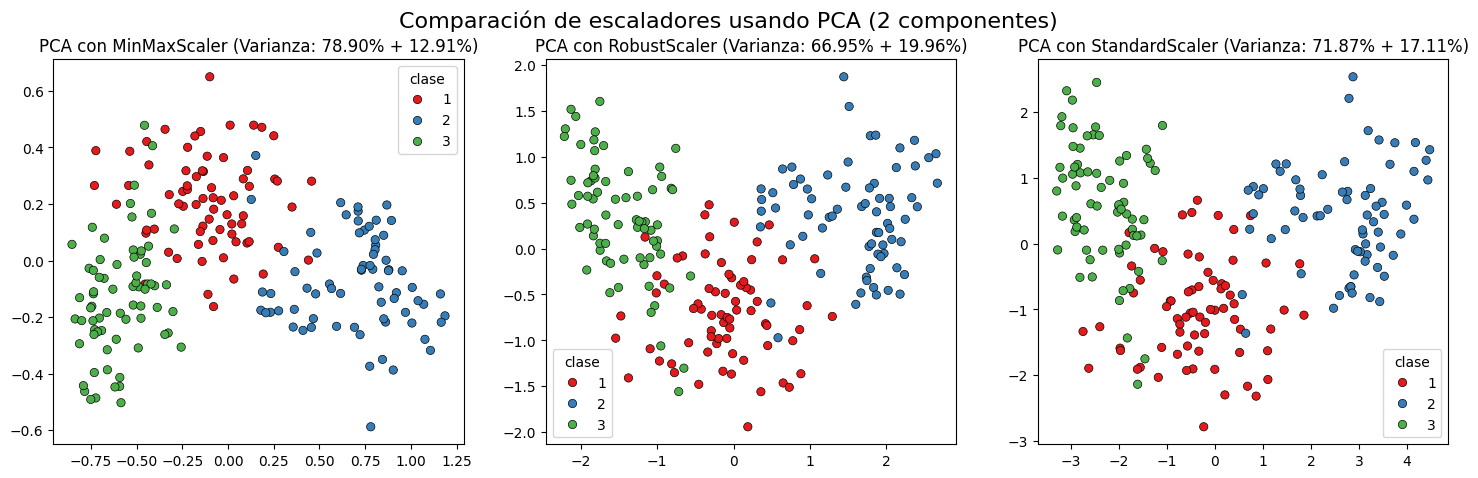

In [5]:
escaladores = {                                                                 # Definimos los escaladores a probar
    'MinMaxScaler': MinMaxScaler(),                                             # Escalador que normaliza los datos en el rango [0, 1]
    'RobustScaler': RobustScaler(),                                             # Escalador robusto que utiliza la mediana y el IQR para minimizar la influencia de outliers
    'StandardScaler': StandardScaler()                                          # Escalador que estandariza los datos restando la media y dividiendo por la desviación estándar
}

figura_completa, ejes = plt.subplots(1, 3, figsize=(18, 5))                     # Preparamos una figura para comparar los PCA de cada escalado

objetivo = dataframe_semillas['clase']                                          # Obtenemos la variable objetivo
atributos = dataframe_semillas.drop(columns=['clase'])                          # Obtenemos los atributos (X) del dataset

contador = 0                                                                    # Inicializamos un contador para recorrer cada uno de los subplots

for elem in escaladores:                                                        # Recorremos cada uno de los escaladores

    escalador_actual = escaladores[elem]                                        # Obtenemos el escalador actual
    X_escalado = escalador_actual.fit_transform(atributos)                      # Escalamos los datos

    modelo_pca = PCA(n_components=2, random_state=NIA)                          # Definimos el PCA con 2 componentes para reproducibilidad
    X_pca = modelo_pca.fit_transform(X_escalado)                                # Aplicamos PCA a los datos escalados
    explained_variance = modelo_pca.explained_variance_ratio_                   # Obtenemos la varianza explicada de cada componente

    eje_actual = ejes[contador]                                                 # Obtenemos el eje correspondiente

    sns.scatterplot(                                                            # Graficamos los datos en el eje actual
        x=X_pca[:, 0],                                                          # Primer componente principal en el eje X
        y=X_pca[:, 1],                                                          # Segundo componente principal en el eje Y
        hue=objetivo,                                                           # Coloreamos según la variable objetivo 'clase'
        palette= 'Set1',                                                        # Establecemos el mapa de colores a 'Set1'
        edgecolor='black',                                                      # Establecemos el color del borde de cada punto a negro
        ax=eje_actual                                                           # Indicamos en cuál subplot se dibuja
    )

    titulo = "PCA con {} (Varianza: {:.2%} + {:.2%})".format(elem, explained_variance[0], explained_variance[1])      # Establecemos el título del subplot
    eje_actual.set_title(titulo)                                                                                      # Asignamos el título al subplot

    contador += 1                                                               # Pasamos al siguiente subplot

plt.suptitle("Comparación de escaladores usando PCA (2 componentes)", fontsize=16)  # Título general de la figura
plt.show()                                                                          # Mostramos la figura con todos los subplots

Como podemos observar en las gráficas, MinMaxScaler consigue la representación en dos dimensiones en la que se aprecia una mayor separación y agrupación de las clases, ya que normaliza los datos en un rango uniforme [0,1].

Además, la evaluación analítica con la varianza explicada muestra un mayor porcentaje en las dos primeras componentes, lo que respalda nuestra elección de MinMaxScaler como el escalador más apropiado para el problema.

### **3. CLUSTERING USANDO LOS DATOS TRANSFORMADOS (2D)**

Elegido MinMaxScaler como el escalador más apropiado, aplicaremos tres técnicas de clustering con la representación en dos dimensiones mediante PCA y MinMaxScaler.

El clustering persigue el objetivo de encontrar agrupaciones significativas en los datos ante la ausencia de la variable de respuesta. Implementaremos y compararemos las siguientes técnicas de clustering:

- **K-Means**: encontramos el número óptimo de clusters utilizando el método del codo y el índice de silhouette.
- **Clustering jerárquico**: aplicamos técnicas aglomerativas con sklearn, y representamos los resultados a través de dendogramas. Para ello, usaremos funciones de linkage: ward, average y complete.
- **DBSCAN**: identificamos agrupaciones basadas en densidad, y detectamos posibles outliers en los datos. Es necesario ajustar hiperparámetros como: minpts y eps.



**Preparamos los datos con MinMaxScaler y PCA**

Realizamos una transformación de los datos utilizando un Pipeline para combinar el escalado con MinMaxScaler y PCA para reducir la dimensionalidad a 2 componentes.

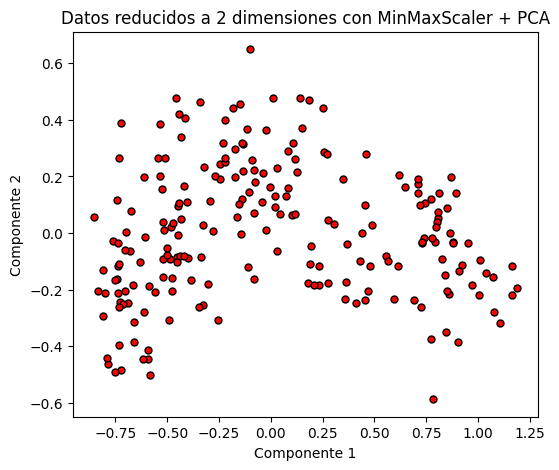

In [6]:
from sklearn.pipeline import Pipeline                                           # Importamos el Pipeline

pipe = Pipeline([                                                               # Creamos un Pipeline
    ('scaler', MinMaxScaler()),                                                 # Primer paso: elegimos el mejor escalador
    ('pca', PCA(n_components=2, random_state=NIA))                              # Segundo paso: aplicamos PCA para reducir la dimensionalidad a 2 componentes; se utiliza NIA como semilla para reproducibilidad
])

X_2d = pipe.fit_transform(atributos)                                            # Entrenamos el Pipeline a los datos 'atributos' y transformamos dichos datos a 2 dimensiones; se guarda el resultado en X_2d

plt.figure(figsize=(6, 5))                                                      # Creamos una figura para visualizar el gráfico
plt.scatter(X_2d[:, 0],                                                         # Usamos la primera columna de X_2d (primer componente principal) para el eje X
            X_2d[:, 1],                                                         # Usamos la segunda columna de X_2d (segundo componente principal) para el eje Y
            s=25,                                                               # Establecemos el tamaño de cada punto a 25
            color='red',                                                        # Establecemos el color de cada punto a rojo
            edgecolor='black'                                                   # Establecemos el color del borde de cada punto a negro
            )

plt.title("Datos reducidos a 2 dimensiones con MinMaxScaler + PCA")             # Asignamos un título al gráfico
plt.xlabel("Componente 1")                                                      # Asignamos un título al eje X
plt.ylabel("Componente 2")                                                      # Asignamos un título al eje Y
plt.show()                                                                      # Mostramos el gráfico en pantalla

**KMeans**

K-Means agrupa los datos en K clusters, minimizando la distancia entre cada punto y el centroide de su grupo. Asigna iterativamente los puntos al cluster más cercano y recalcula los centroides. Para determinar el número óptimo de clusters, emplearemos: Método del codo (Elbow Method) e índice silhouette.

- Método del codo

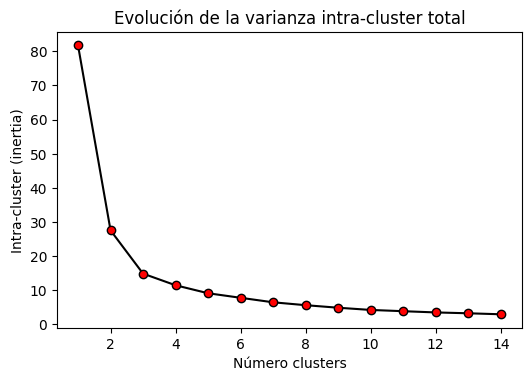

In [7]:
from sklearn.cluster import KMeans                                              # Importamos KMeans

range_n_clusters = range(1, 15)                                                 # Definimos un rango de clusters para probar
inertias = []                                                                   # Inicializamos una lista para almacenar las inercias

for n_clusters in range_n_clusters:                                             # Recorremos cada cluster
    modelo_kmeans = KMeans(                                                     # Definimos un modelo KMeans
                           n_clusters=n_clusters,                               # Creamos un modelo KMeans con el número de clusters actual
                           n_init=20,                                           # Ponemos 20 inicializaciones
                           random_state=NIA                                     # Fijamos la semilla para reproducibilidad
                           )
    modelo_kmeans.fit(X_2d)                                                     # Entrenamos el modelo con los datos en 2d (X_2d)
    inertias.append(modelo_kmeans.inertia_)                                     # Guardamos en la lista la inercia del modelo

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))                                 # Creamos una figura para visualizar el gráfico
ax.plot(
    range_n_clusters,                                                           # En el eje X el número de clusters
    inertias,                                                                   # Es la inercia correspondiente a cada k en el eje Y
    marker='o',                                                                 # Ponemos un marcador circular para destacar cada punto en la curva
    color='black',                                                              # Ponemos el color de la línea a negro
    markerfacecolor='red',                                                      # Rellenamos los puntos de rojo
    markeredgecolor='black'                                                     # Ponemos el borde de los puntos a negro
)

ax.set_title("Evolución de la varianza intra-cluster total")                    # Añadimos un título al gráfico
ax.set_xlabel('Número clusters')                                                # Etiquetamos el eje X indicando el número de clusters
ax.set_ylabel('Intra-cluster (inertia)');                                       # Etiquetamos el eje Y indicando la inercia

En las gráficas del método del codo, buscamos el punto donde la reducción de la inercia comienza a decrementar su valor de forma muy suave, es decir, se forma un codo.

Podemos observar como el valor óptimo es K=3, como ya suponíamos tras visualizar los datos, puesto que dividir los datos en más de 3 grupos no aporta tanta mejora.

- Índice silhouette

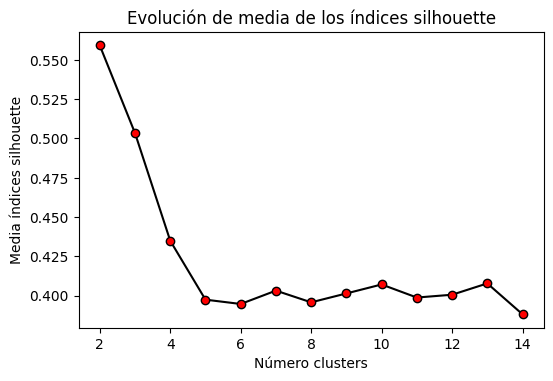

In [8]:
from sklearn.metrics import silhouette_score                                    # Importamos la función silhouette_score para evaluar la calidad de nuestros clusters

range_n_clusters = range(2, 15)                                                 # Definimos un rango de posibles números de clusters (desde 2 hasta 14) para probar distintas configuraciones
valores_medios_silhouette = []                                                  # Inicializamos una lista para almacenar los valores medios de silhouette para cada número de clusters

for n_clusters in range_n_clusters:                                             # Recorremos cada número de clusters
    modelo_kmeans = KMeans(                                                     # Definimos un modelo KMeans
                          n_clusters=n_clusters,                                # Establecemos el número de clusters actual
                          n_init=25,                                            # Ponemos 20 inicializaciones
                          random_state=NIA                                      # Fijamos la semilla para reproducibilidad
                          )
    cluster_labels = modelo_kmeans.fit_predict(X_2d)                            # Entrenamos el modelo y obtenemos las etiquetas de los clusters
    silhouette_avg = silhouette_score(X_2d, cluster_labels)                     # Calculamos el índice silhouette para evaluar la calidad de los clusters
    valores_medios_silhouette.append(silhouette_avg)                            # Guardamos el valor medio de silhouette en la lista

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))                                 # Creamos una figura para visualizar el gráfico
ax.plot(
    range_n_clusters,                                                           # Eje X: valores de K (2–14)
    valores_medios_silhouette,                                                  # Eje Y: silhouette medio para cada K
    marker='o',                                                                 # Marcador circular
    linestyle='-',                                                              # Línea continua
    color='black',                                                              # Línea en negro
    markerfacecolor='red',                                                      # Relleno de marcadores en rojo
    markeredgecolor='black'                                                     # Borde de marcadores en negro
)
ax.set_title("Evolución de media de los índices silhouette")                    # Añadimos un título al gráfico
ax.set_xlabel('Número clusters')                                                # Etiquetamos el eje X para indicar que representa el número de clusters
ax.set_ylabel('Media índices silhouette');                                      # Etiquetamos el eje Y para indicar que muestra la media de los índices silhouette

En las gráficas del índice de silhouette buscamos el punto donde el valor del índice alcanza su máximo, lo que indica una mejor separación de los clusters.

Podemos observar como el valor óptimo es n_clusters=2 o incluso n_clusters=3, lo que nos indica que los grupos están bien separados. A medida que se incrementa el número de clusters, el índice disminuye y la configuración se aleja de la optimalidad.

- Aplicación final de KMeans

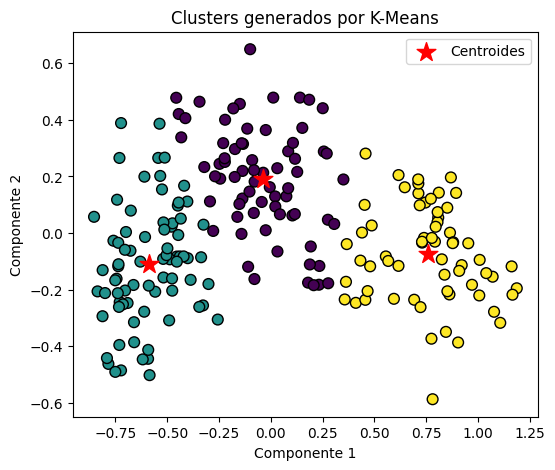

In [9]:
km_final = KMeans(n_clusters=3, n_init=25, random_state=NIA)                    # Creamos un KMeans con 3 clusters, 25 inicializaciones y semilla NIA para reproducibilidad
clusters_km = km_final.fit_predict(X_2d)                                        # Entrenamos el KMeans usando los datos en 2d (X_2d) y asignamos cada punto a un cluster

plt.figure(figsize=(6, 5))                                                      # Creamos una figura para visualizar el gráfico

# ═══════════════════════════ Dibujamos los puntos ═════════════════════════════

plt.scatter(x = X_2d[:, 0],                                                     # Graficamos los puntos, primera componente para el eje X
            y = X_2d[:, 1],                                                     # Graficamos los puntos, segunda componente para el eje Y
            c=clusters_km,                                                      # Coloreamos los puntos de cada cluster
            s=60,                                                               # Tamaño de cada punto
            edgecolor='black')                                                  # Ponemos el borde de cada punto a negro

# ═══════════════════ Dibujamos los centroides (estrellitas) ═══════════════════

plt.scatter(km_final.cluster_centers_[:, 0],                                    # Dibujamos los centroides, primera coord de cada centroide para el eje X
            km_final.cluster_centers_[:, 1],                                    # Dibujamos los centroides, segunda coord de cada centroide para el eje Y
            c='red',                                                            # Coloreamos los centroides en rojo
            s=200,                                                              # Ponemos un tamaño muy alto para destacar los centroides
            marker='*',                                                         # Ponemos que los centroides sean una estrellita
            label='Centroides')                                                 # Ponemos un label para la leyenda

plt.title("Clusters generados por K-Means")                                     # Asignamos un título al gráfico
plt.xlabel("Componente 1")                                                      # Asignamos un título al eje X
plt.ylabel("Componente 2")                                                      # Asignamos un título al eje Y
plt.legend()                                                                    # Mostramos la leyenda
plt.show()                                                                      # Mostramos el gráfico en pantalla

En el modelo final de K-Means podemos apreciar tres grupos de puntos, cada uno con un color distinto. Los centroides aparecen con estrellitas rojas, en el centro de cada conjunto.

Observamos que K-Means ha logrado encontrar tres clusters en los datos 2D, que se concentran alrededor de su centroide. La separación entre clusters es buena, por lo que nuestra decisión de elegir K=3 como número óptimo de clusters es acertada.

**Clustering jerárquico (dendogramas)**

El clustering jerárquico (dendogramas) organiza los datos en una estructura de árbol, donde en cada nodo se representa la fusión o separación de los clusters hasta conseguir llegar a un único cluster que incluye a todos los datos.

Visualizamos los resultados mediante un dendograma, que nos permite analizar de forma visual a través de cortes en la altura el número óptimo de clusters.

- Función para representar un dendograma

In [10]:
from scipy.cluster.hierarchy import dendrogram                                  # Importamos la función 'dendrogram' para graficar el dendrograma
from sklearn.cluster import AgglomerativeClustering                             # Importamos el modelo de clustering jerárquico


def plot_dendrogram(model, **kwargs):                                           # Definimos la función 'plot_dendrogram' que toma un modelo de clustering y argumentos adicionales para graficar
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])                                 # Obtenemos el número de muestras en cada cluster
    n_samples = len(model.labels_)                                              # Obtenemos el número total de muestras a partir de los labels del modelo
    for i, merge in enumerate(model.children_):                                 # Recorremos cada fusión de clusters
        current_count = 0                                                       # Inicializamos el contador de muestras en el cluster actual
        for child_idx in merge:                                                 # Recorremos cada índice de los nodos que se fusionan en esta iteración
            if child_idx < n_samples:                                           # Si el índice es menor que el número total de muestras, es un cluster
                current_count += 1  # leaf node                                 # Incrementamos el contador en 1 para cada nodo hoja
            else:                                                               # Si el índice es mayor o igual a n_samples, se trata de un nodo ya fusionado
                current_count += counts[child_idx - n_samples]                  # Sumamos al contador el número de muestras que ya se han fusionado en ese nodo
        counts[i] = current_count                                               # Guardamos el valor del contador en counts

    linkage_matrix = np.column_stack([model.children_,                          # Creamos la matriz de enlace combinando
                                      model.distances_,                         #  Ponemos los índices de las fusiones,
                                      counts]).astype(float)                    #  Ponemos las distancias de fusión y el número de muestras en cada fusión, convirtiéndola a tipo float

    # Plot
    dendrogram(linkage_matrix, **kwargs)                                        # Finalmente, graficamos el dendrograma usando la 'linkage_matrix' y cualquier argumento adicional

 - Comparamos los resultados con los linkages complete, ward y average

In [11]:
modelo_hclust_complete = AgglomerativeClustering(                               # Creamos el modelo de clustering jerárquico: Linkage complete
    metric = 'euclidean',                                                       # Usamos la distancia euclidiana para medir similitud entre puntos
    linkage  = 'complete',                                                      # Configuramos el linkage a 'complete', que considera la máxima distancia entre los puntos de los clusters
    distance_threshold = 0,                                                     # Establecemos el umbral de distancia a 0 para obtener el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_complete.fit(X=X_2d)                                              # Ajustamos el modelo a los datos transformados a 2 dimensiones

modelo_hclust_average = AgglomerativeClustering(                                # Creamos el modelo de clustering jerárquico: Linkage average
    metric = 'euclidean',                                                       # Usamos la distancia euclidiana para medir similitud entre puntos
    linkage  = 'average',                                                       # Configuramos el linkage a 'average', que usa la distancia promedio entre los puntos de los clusters
    distance_threshold = 0,                                                     # Umbral de distancia en 0 para ver el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_average.fit(X=X_2d)                                               # Ajustamos el modelo a los datos transformados a 2 dimensiones

modelo_hclust_ward = AgglomerativeClustering(                                   # Creamos el modelo de clustering jerárquico: Linkage ward
    linkage  = 'ward',                                                          # Usamos la distancia euclidiana para medir similitud entre puntos
    distance_threshold = 0,                                                     # Umbral de distancia en 0 para ver el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_ward.fit(X=X_2d)                                                  # Ajustamos el modelo a los datos transformados a 2 dimensiones

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

- Representamos los dendogramas

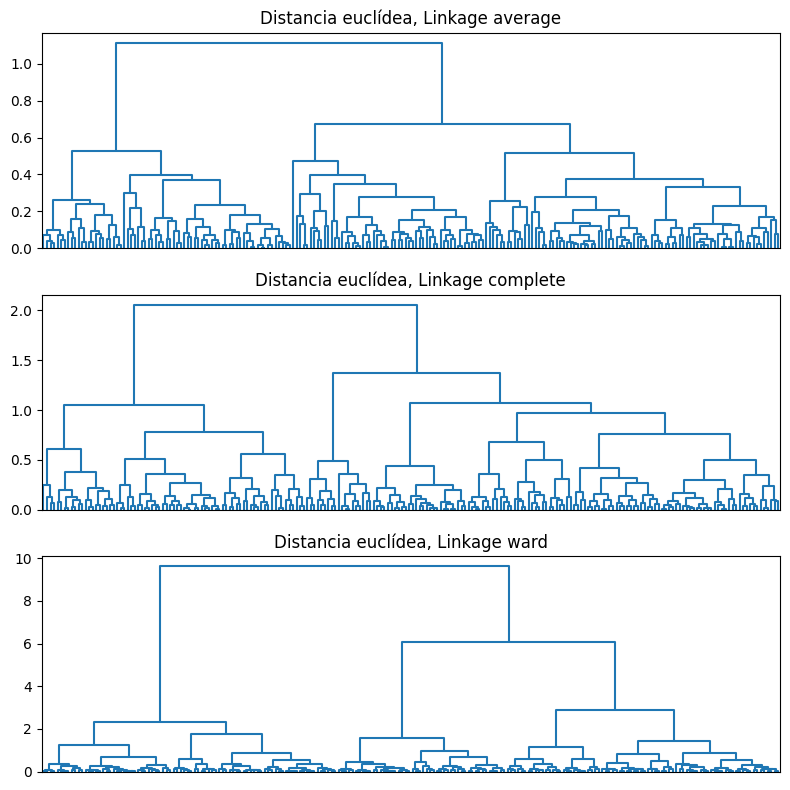

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))                                   # Creamos una figura con 3 subplots en una columna

plot_dendrogram(modelo_hclust_average, labels=dataframe_semillas.index, color_threshold=0, ax=axs[0])     # Dibujamos el dendrograma para linkage "average" en el primer subplot
axs[0].set_title("Distancia euclídea, Linkage average")                                                   # Asignamos el título al primer subplot
axs[0].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del primer subplot

plot_dendrogram(modelo_hclust_complete, labels=dataframe_semillas.index, color_threshold=0, ax=axs[1])    # Dibujamos el dendrograma para linkage "complete" en el segundo subplot
axs[1].set_title("Distancia euclídea, Linkage complete")                                                  # Asignamos el título al segundo subplot
axs[1].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del segundo subplot

plot_dendrogram(modelo_hclust_ward, labels=dataframe_semillas.index, color_threshold=0, ax=axs[2])        # Dibujamos el dendrograma para linkage "ward" en el tercer subplot
axs[2].set_title("Distancia euclídea, Linkage ward")                                                      # Asignamos el título al tercer subplot
axs[2].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del tercer subplot

plt.tight_layout()                                                              # Ajustamos el espacio entre subplots

En cuanto a Linkage average, se fusionan primero los puntos y clusters mas cercanos. Apreciamos como a alturas bajas existen muchas fusiones, lo que indica que los clusters pequeños se van uniendo progresivamente hasta llegar a un único cluster que incluye todos los datos.

Sobre Linkage complete, los clusters se fusionan mediante la máxima distancia entre puntos de grupos diferentes. Observamos que el dendograma es más estricto a la hora de unir clusters, es decir, si los puntos son muy diferentes se fusionarán a una altura mayor.

Por último Linkage ward, los clusters se fusionan minimizando la varianza interna. Notamos una diferencia de altura muy grande donde los grupos pequeños se combinan en un único cluster, debido a que Ward junta los puntos minimizando la dispersión dentro de cada cluster.

- Número de clusters mediante la altura de corte

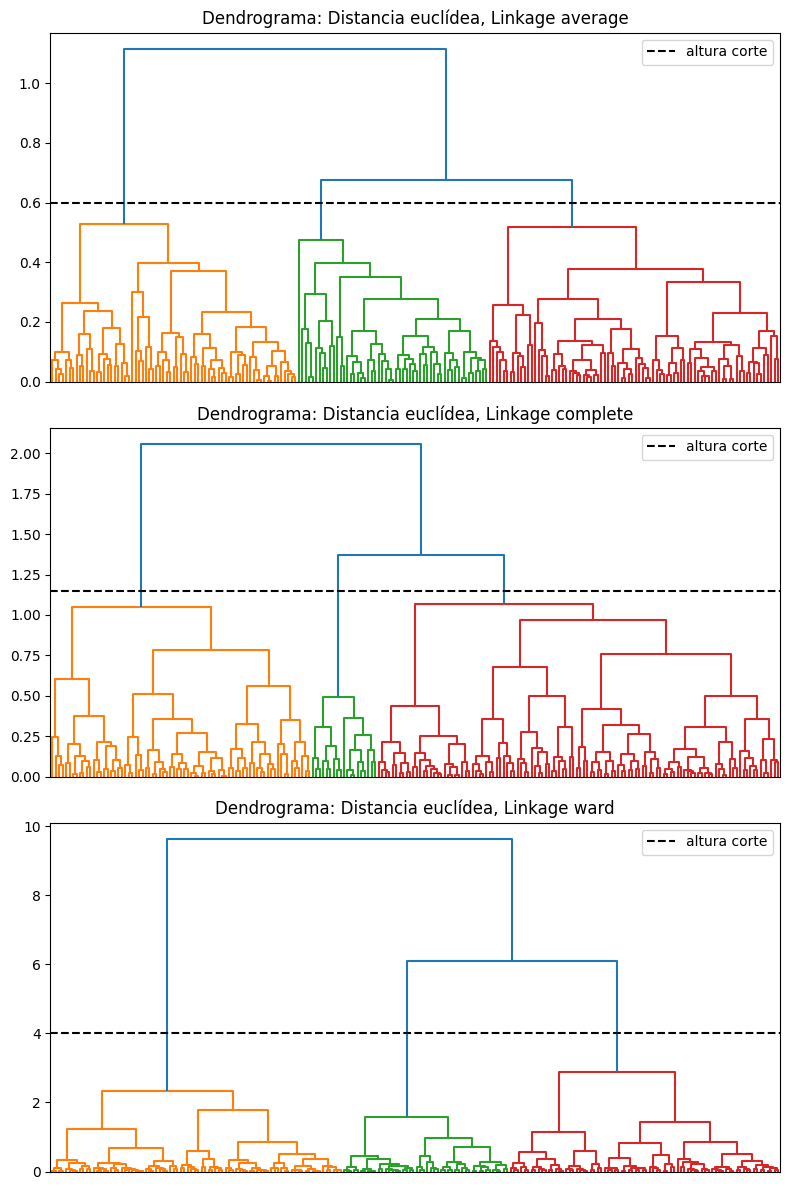

In [13]:
figura, ejes = plt.subplots(3, 1, figsize=(8, 12))                              # Creamos una figura con 3 subplots en una columna y tamaño 8x12

plot_dendrogram(modelo_hclust_average, labels=dataframe_semillas.index, color_threshold=0.6, ax=ejes[0])           # Dibujamos el dendrograma para linkage "average" en el primer subplot, usando los índices del dataframe como etiquetas y estableciendo el umbral de color a 0.6
ejes[0].set_title("Dendrograma: Distancia euclídea, Linkage average")                                              # Asignamos el título al primer subplot
ejes[0].set_xticklabels([])                                                                                        # Eliminamos las etiquetas del eje X del primer subplot
ejes[0].axhline(y=0.6, color='black', linestyle='--', label='altura corte')                                        # Dibujamos una línea horizontal en y=0.6 para marcar la altura de corte
ejes[0].legend()                                                                                                   # Mostramos la leyenda en el primer subplot

plot_dendrogram(modelo_hclust_complete, labels=dataframe_semillas.index, color_threshold=1.15, ax=ejes[1])         # Dibujamos el dendrograma para linkage "complete" en el segundo subplot, con umbral de color a 1.15
ejes[1].set_title("Dendrograma: Distancia euclídea, Linkage complete")                                             # Asignamos el título al segundo subplot
ejes[1].set_xticklabels([])                                                                                        # Eliminamos las etiquetas del eje X del segundo subplot
ejes[1].axhline(y=1.15, color='black', linestyle='--', label='altura corte')                                       # Dibujamos una línea horizontal en y=1.15 para marcar la altura de corte
ejes[1].legend()                                                                                                   # Mostramos la leyenda en el segundo subplot

plot_dendrogram(modelo_hclust_ward, labels=dataframe_semillas.index, color_threshold=4, ax=ejes[2])               # Dibujamos el dendrograma para linkage "ward" en el tercer subplot, con umbral de color a 4
ejes[2].set_title("Dendrograma: Distancia euclídea, Linkage ward")                                                # Asignamos el título al tercer subplot
ejes[2].set_xticklabels([])                                                                                       # Eliminamos las etiquetas del eje X del tercer subplot
ejes[2].axhline(y=4, color='black', linestyle='--', label='altura corte')                                         # Dibujamos una línea horizontal en y=4 para marcar la altura de corte
ejes[2].legend()                                                                                                  # Mostramos la leyenda en el tercer subplot

plt.tight_layout()                                                              # Ajustamos el espacio entre subplots
plt.show()                                                                      # Mostramos la figura completa con los tres dendrogramas

Observamos la línea discontinua que representa la altura de corte en cada uno de los dendogramas.

En cuanto a Linkage average, vemos que a una altura de 0.6 se forman tres grupos principales de colores naranja, verde y rojo. Esta altura refleja la distancia promedio ente los puntos de los clusters.

Sobre Linkage complete, obtenemos tres clusters a una altura de 1.15. Este método es más cuidadoso, vemos como el cluster naranja se separa antes de llegar a una altura de 1, mientras que los otros dos clusters se forman más tarde.

Por último con Linkage ward, trazamos la altura de corte en 4, donde se consiguen identificar tres clusters. Observamos un salto grande en el que se unen casi todos los puntos, visualmente observamos grupos más compactos y con menos dispersión.

- Número de clusters mediante el índice silhouette

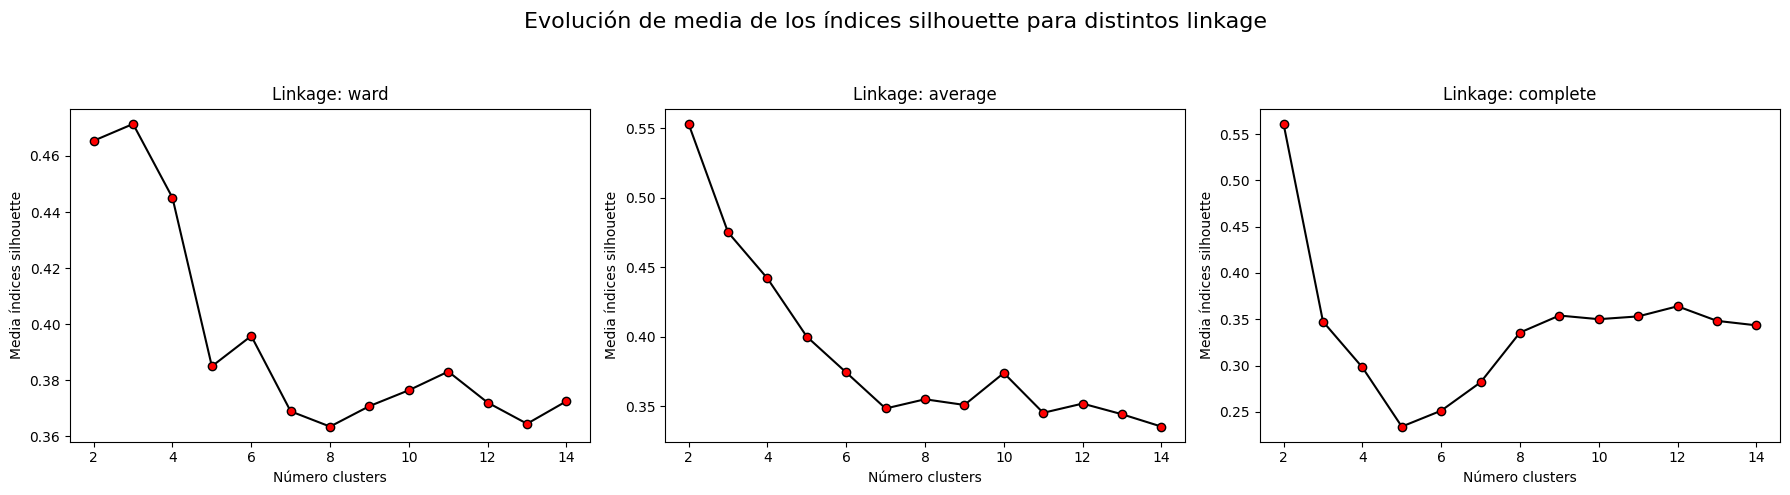

In [14]:
metodos_linkage = {                                                             # Definimos un diccionario con los métodos de linkage a evaluar
    'ward': 'ward',                                                             # Incluimos 'ward'
    'average': 'average',                                                       # Incluimos 'average'
    'complete': 'complete'                                                      # Incluimos 'complete'
}

range_n_clusters = range(2, 15)                                                 # Definimos el rango de números de clusters a probar (de 2 a 15)

figura, ejes = plt.subplots(1, 3, figsize=(18, 5))                                                       # Creamos una figura con 3 subplots en una fila
figura.suptitle("Evolución de media de los índices silhouette para distintos linkage", fontsize=16)      # Ponemos el título principal de la figura

contador = 0                                                                    # Inicializamos un contador para recorrer los subplots

for nombre_linkage in metodos_linkage:                                          # Iteramos sobre cada método de linkage definido en el diccionario
    metodo_linkage = metodos_linkage[nombre_linkage]                            # Obtenemos el valor del método de linkage actual
    valores_medios_silhouette = []                                              # Inicializamos la lista para almacenar los índices silhouette medios

    for n_clusters in range_n_clusters:                                         # Probamos cada número de clusters dentro del rango definido
        modelo = AgglomerativeClustering(                                       # Creamos un modelo de clustering aglomerativo
            metric = 'euclidean',                                               # Usamos la métrica de distancia euclidiana
            linkage = metodo_linkage,                                           # Usamos el método de linkage actual (ward, average o complete)
            n_clusters = n_clusters                                             # Establecemos el número de clusters
        )

        cluster_labels = modelo.fit_predict(X_2d)                               # Entrenamos el modelo y asignamos cada punto a un cluster
        silhouette_avg = silhouette_score(X_2d, cluster_labels)                 # Calculamos el índice silhouette para evaluar la calidad de los clusters
        valores_medios_silhouette.append(silhouette_avg)                        # Guardamos el valor medio de silhouette en la lista

    eje_actual = ejes[contador]                                                 # Seleccionamos el subplot correspondiente según el contador

    eje_actual.plot(                                                            # Graficamos la evolución del índice silhouette
        range_n_clusters,                                                       # Eje X: valores de K
        valores_medios_silhouette,                                              # Eje Y: silhouette medio para cada K
        marker='o',                                                             # Marcador circular
        color='black',                                                          # Línea en negro
        markerfacecolor='red',                                                  # Relleno de marcadores en rojo
        markeredgecolor='black'                                                 # Borde de marcadores en negro
    )
    eje_actual.set_title("Linkage: " + nombre_linkage)                          # Asignamos el título del subplot indicando el método de linkage
    eje_actual.set_xlabel('Número clusters')                                    # Etiqueta del eje X
    eje_actual.set_ylabel('Media índices silhouette')                           # Etiqueta del eje Y

    contador += 1                                                               # Incrementamos el contador para el siguiente subplot

plt.tight_layout(rect=[0, 0, 1, 0.93])                                          # Ajustamos el espacio entre subplots
plt.show()                                                                      # Mostramos la figura con todos los subplots

Observamos y comparamos cómo varía el índice silhouette al cambiar el número de clusters para cada método.

En cuanto a Linkage average, el valor de silhouette más alto se obtiene con 2 clusters, en torno a 0.46. Con 3 clusters, obtenemos un valor muy bueno también alrededor de 0.43. A partir de 4 clusters, el índice desciende de manera más significativa lo que no indica mejora.

Sobre Linkage complete, el mayor índice se obtiene cuando se utilizan 2 clusters, sobre 0.57, siendo este el mayor pico de todos. Del mismo modo que en el anterior, a medida que incrementan los clusters, el valor desciende mucho.

Por último con Linkage ward, obtenemos el mejor índice con 3 clusters en torno a 0.50. Con 4 clusters obtenemos un valor muy bueno también, sobre 0.45. Y como en los anteriores, a medida que se aumentan los clusters, el índice disminuye.

Concluimos identificando que el mejor índice de silhouette se obtiene con Linkage complete, utilizando 2 clusters. Sin embargo, en nuestro caso 2 clusters es demasiado general, y es por ello que revisamos el siguiente mejor pico con 3 clusters, siendo Linkage ward con el que continuaremos.

- Modelo final con el número óptimo de clusters

In [15]:
modelo_hclust_ward = AgglomerativeClustering(                                   # Creamos el modelo de clustering jerárquico
    linkage  = 'ward',                                                          # Usamos el método 'ward' que minimiza la varianza intra-cluster
    n_clusters = 3                                                              # Establecemos el número óptimo de clusters a 3
)
modelo_hclust_ward.fit(X=X_2d)                                                  # Entrenamos el modelo con los datos en 2d (X_2d)

AgglomerativeClustering(n_clusters=3)

**DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) forma clústers basados en densidad, es decir, agrupa en clústers a aquellos puntos cercanos entre sí y deja como outliers a aquellos alejados.

Este método se regula por dos hiperparámetros:

*   eps: indicando el radio de distancia de cada punto para considerar a otro como vecino o no.
*   min_samples: indicando el número mínimo de puntos para formar un cluster.

Para probar este algoritmo, empezaremos creando un modelo inicial y después ajustaremos los hiperparámetros para conseguir el mejor resultado posible.



*   Importación



In [16]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

- Lectura de datos

In [17]:
datos = pd.read_csv('DBSCAN.csv')
datos.head()

,x,y,shape
0,-0.803739,-0.853053,1
1,0.852851,0.367618,1
2,0.927180,-0.274902,1
3,-0.752626,-0.511565,1
4,0.706846,0.810679,1


- Modelo inicial de DBSCAN

Creamos un modelo inicial con eps = 0.2 y min_samples = 5.

In [18]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_2d)

DBSCAN(eps=0.2)

- Clasificación mediante DBSCAN

Ahora usamos dicho modelo para generar clústers en nuestro conjunto de datos.

Número de clusters encontrados: 1
Número de outliers encontrados: 1


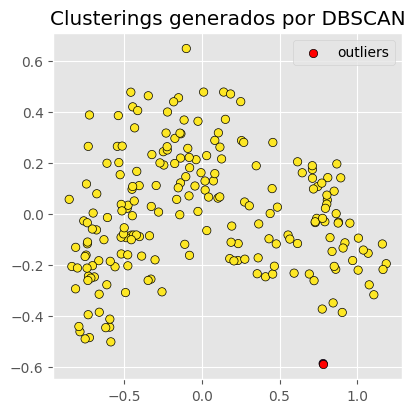

In [19]:
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_2d[:, 0],
    y = X_2d[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_2d[labels == -1, 0],
    y = X_2d[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Hemos obtenido 1 solo clúster (puntos en amarillo) y 1 punto ruidoso (punto rojo).

- Determinamos una eps adecuada

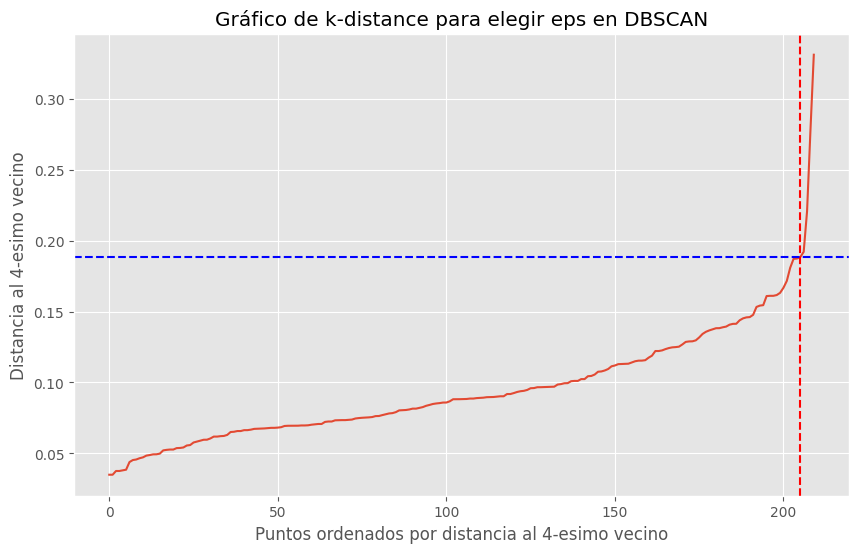

x_point=205 y_value=0.1883725581332985


In [20]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_2d)
distances, indices = nn.kneighbors(X_2d)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 205
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

El valor óptimo encontrado es eps=0.18837, que aproximaremos a eps=0.19. Probamos de nuevo el algoritmo con este nuevo valor.


- Aplicación final de DBSCAN

Número de clusters encontrados: 1
Número de outliers encontrados: 2


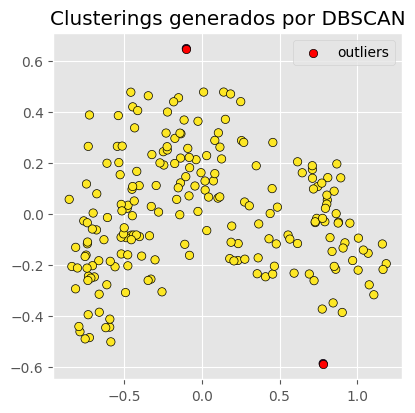

In [21]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = y_value,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_2d)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_2d[:, 0],
    y = X_2d[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_2d[labels == -1, 0],
    y = X_2d[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

El resultado obtenido por DBSCAN es un solo clúster agrupando a la mayoría de los puntos (puntos amarillos) y 2 puntos ruidosos que no entran en el clúster por estar demasiado alejados (puntos rojos).

---

### **4. ANÁLISIS Y EVALUACIÓN DE RESULTADOS**

En este apartado nos centraremos en la evaluación de los tres métodos de Clustering que hemos utilizado: K-Means, Jerárquico y DBSCAN.



**Comprobación visual de los métodos de Clustering**

Las gráficas que se muestran en el apartado anterior nos proporcionan la siguiente información:
-  K-Means: nos muestra 3 clusters bien diferenciados, con los centroides posicionados en el centro de cada cluster y una buena separación entre clusters.
- Dendogramas: siendo Linkage average el que muestra una estructura más gradual de combinación de clusters, Linkage complete el que muestra combinaciones a mayores distancias y Linkage ward el que presenta el salto más claro para identificar los tres clusters.
- DBSCAN: al estar los puntos relativamente juntos en el plano, el resultado obtenido de DBSCAN es un 1 cluster y 2 puntos ruidosos.

La comparación visual de los métodos nos lleva a las siguientes conclusiones:
- K-Means y Dendogramas usando Linkage ward son capaces de capturar la estructura de 3 clusters de forma evidente en los datos.
- El corte en el dendograma usando Linkage ward a una altura de ~4 nos confirma que 3 clusters son posibles.
- DBSCAN, en cambio, no consigue separar correctamente los clusters y no nos resulta útil en este conjunto de datos.

Entonces, podemos decir que K-Means (k=3) o Dendogramas con Linkage ward (3 clusters) son buenos métodos para utilizar en este conjunto de semillas.

**Relación entre clusters obtenidos y clases de semillas originales**

In [22]:
print("K‑Means vs. clase original:")
display(pd.crosstab(clusters_km, dataframe_semillas['clase']))

# Interpretar y hacer con el resto de métodos, por ahora está K-Means  vs clase original

K‑Means vs. clase original:


clase,1,2,3
row_0,,,
0,58,9,3
1,10,0,67
2,2,61,0


**Interpretación de clusters con boxplots**

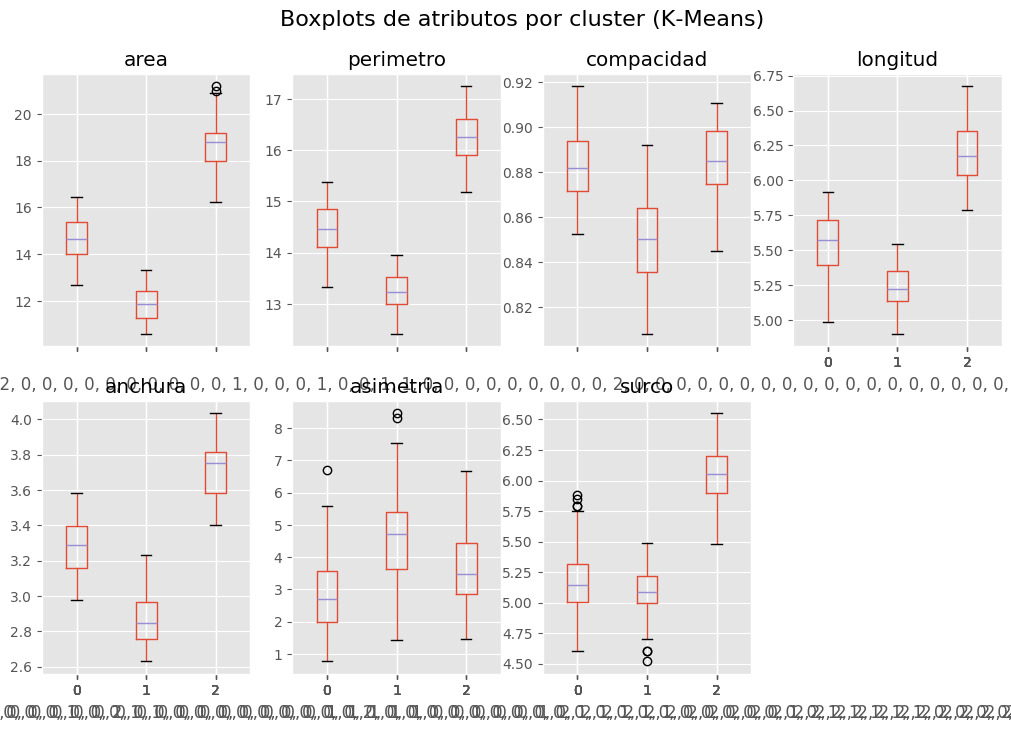

In [23]:
import matplotlib.pyplot as plt

features = [c for c in dataframe_semillas.columns if c != 'clase']

dataframe_semillas[features].boxplot(
    by       = list(clusters_km),
    column   = features,
    layout   = (2, 4),
    figsize  = (12, 8),
    sharey   = False
);

plt.suptitle("Boxplots de atributos por cluster (K‑Means)", fontsize=16)
plt.title("")
plt.xlabel("Cluster K‑Means")
plt.show()

# Esto es con K-Means, habria que hacerlo para todos e interpretarlo. (Quizás este de K-Means este mal hecho, tengo que revisar)